In [48]:
# Tools 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from mlxtend.plotting import plot_decision_regions

# Sklearn 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Statsmodels 
import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(1111)

### Generamos muestras 

Primero vamos a generar los datos, recordemos que $Y \sim \textbf{Bern}(0.5)$ y que $X | Y=0 \sim \mathcal{N}((0, 0), \mathbb{A})$, $X | Y=1 \sim \mathcal{N}((1, 2), \mathbb{A})$. Entonces primero generemos muestras de $Y$ y posteriormente generemos muestras de $X$ condicionadas a $Y$

In [5]:
# Covariance matriz and mean vectors 
A = np.array([
    [1.0, 0.4], 
    [0.4,   1]
])
mu0 = np.zeros(2)
mu1 = np.array([1.0, 2.0])

# Generate data 
samples_X = []
samples_Y  = []

for num_sample in [50, 100, 500]:
    sample_Y = np.random.binomial(n=1, p=0.5, size=num_sample)
    sample_X = np.array([
        np.random.multivariate_normal(mu1, A) if sample_Y[i] else  np.random.multivariate_normal(mu0, A) for i in range(num_sample)
    ])
    samples_X.append(sample_X)
    samples_Y.append(sample_Y)

Visualicemos los datos para cada tamaño de muestra 

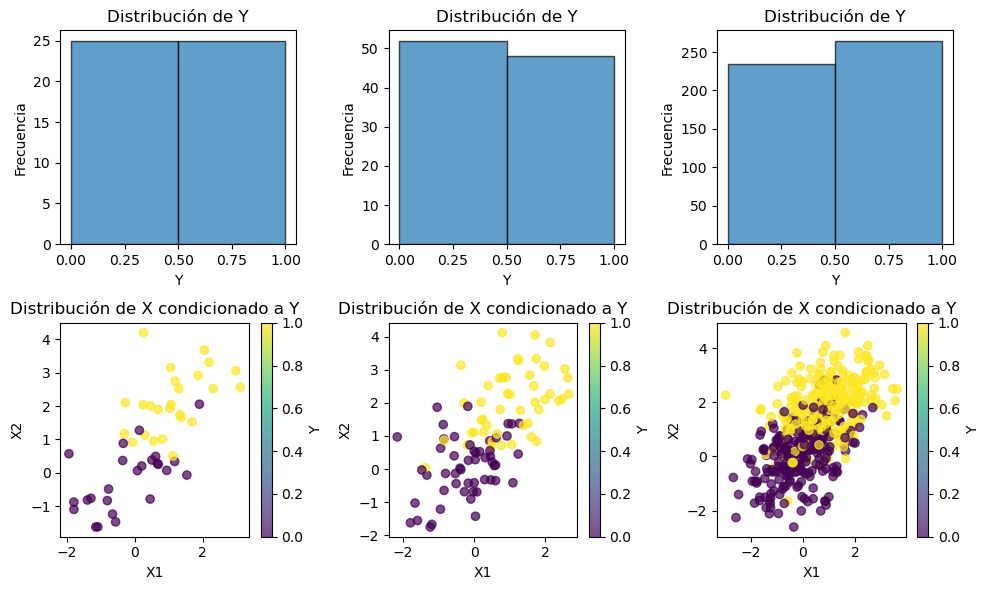

In [6]:
# Visualize data 
plt.figure(figsize=(10, 6))

for i in range(3):
    # Subplot for Y
    plt.subplot(2, 3, i+1)
    plt.hist(samples_Y[i], bins=2, edgecolor='k', alpha=0.7)
    plt.title('Distribución de Y')
    plt.xlabel('Y')
    plt.ylabel('Frecuencia')

    # Subplot for X
    plt.subplot(2, 3, i+4)
    plt.scatter(samples_X[i][:, 0], samples_X[i][:, 1], c=samples_Y[i], cmap='viridis', alpha=0.7)
    plt.title('Distribución de X condicionado a Y')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.colorbar(label='Y')

plt.tight_layout()
plt.show()


### Clasificador Bayesiano Óptimo 


(1) Tenemos que encontrar $ \hat{Y} $ tal que 

$$ \min_{\hat{Y}} \mathbb{E}_{X,Y} [ L(Y, \hat{Y}(X)) ]

= \min_{\hat{Y}} \mathbb{E}_X \left[ \mathbb{E}_{Y|X} L(Y, \hat{Y}(X)) \right]

$$

luego, esto es equivalente a

(1) Tenemos que encontrar $ \hat{Y} $ tal que 

$$ \min_{\hat{Y}} \mathbb{E}_{X,Y} [ L(Y, \hat{Y}(X)) ]

= \min_{\hat{Y}} \mathbb{E}_X \left[ \mathbb{E}_{Y|X} L(Y, \hat{Y}(X)) \right]

$$

luego, esto es equivalente a

$$ \min_{\hat{Y}(x)} \mathbb{E}_{Y|X=x} L(Y, \hat{Y}(x)) \tag{*} $$

como $Y \sim \text{Bern}(0.5)$ estamos en el caso de clasificación binaria $Y \in \{0,1\}$. Desarrollando el término en (*) nos queda como:

$$ L(0, \hat{Y}(x)) P(Y=0 \mid X=x) + L(1, \hat{Y}(x)) P(Y=1 \mid X=x) $$

Si $ \hat{Y}(x) = 0 $, entonces:

$$ L(1,0) P(Y=1 \mid X=x) $$

Si $ \hat{Y}(x) = 1 $, entonces:

$$ L(0,1) P(Y=0 \mid X=x) $$

Por lo tanto:

$$
\hat{Y}(x) = \mathbb{1} \left( L(1,0)P(Y=1 \mid X=x) > L(0,1)P(Y=0 \mid X=x) \right)
$$

Como $L$ es simétrica, $L(1,0)$ y $L(0,1)$ se cancelan a ambos lados de la desigualdad, nos queda:

$$
\hat{Y}(x) = \mathbb{1} \left( \frac{P(Y=1 \mid X=x)}{P(Y=0 \mid X=x)} > 1 \right)
$$

Usando el teorema de Bayes:

$$
\hat{Y}(x) = \mathbb{1} \left( \frac{P(X \mid Y=1)P(Y=1)}{P(X \mid Y=0)P(Y=0)} > 1 \right)
$$

$$
= \mathbb{1} \left( \frac{\exp \left( -\frac{1}{2} (x - \nu)^T \Lambda^{-1} (x - \nu) \right)}{\exp \left( -\frac{1}{2} x^T \Lambda^{-1} x \right)} > 1 \right)
$$

$$
= \mathbb{1} \left( \exp \left( \frac{1}{2} x^T \Lambda^{-1} x - \frac{1}{2} (x - \nu)^T \Lambda^{-1} (x - \nu) \right) > 1 \right)
$$

$$
= \mathbb{1} \left( \exp \left( \frac{1}{2} x^T \Lambda^{-1} \nu + \frac{1}{2} \nu^T \Lambda^{-1} x - \frac{1}{2} \nu^T \Lambda^{-1} \nu \right) > 1 \right)
$$

Como $\Lambda$ es simétrica podemos agrupar los primeros dos términos de la exponencial, luego de hacer las cuentas:

$$
= \mathbb{1} \left( e^{x_1(0.23) + x_2(1.9) - 2.02} > 1 \right)
$$

$$
= \mathbb{1} \left( x_1(0.23) + x_2(1.9) > 3.02 \right)
$$



Veamos los resultados del clasificador bayesiano óptimo 

Accuracy Clasificador Bayesiano Óptimo N=500: 0.806


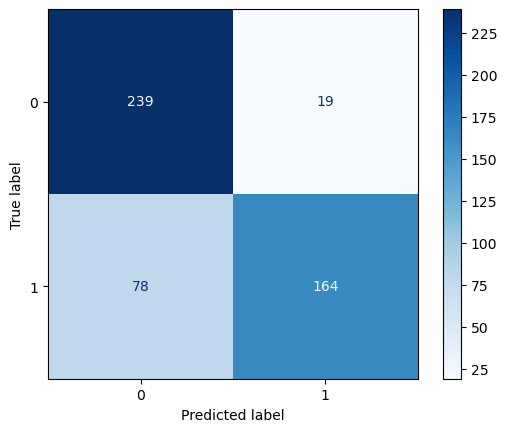

In [96]:
def clas_bay_optim(x):
    return x[0] * 0.23 + x[1] * 1.9 > 3.02

y_pred_500 = [clas_bay_optim(data) for data in samples_X[2]] 
acc_bay_optim = accuracy_score(y_pred_500, samples_Y[2])

print(f"Accuracy Clasificador Bayesiano Óptimo N=500: {acc_bay_optim}")
disp = ConfusionMatrixDisplay(confusion_matrix(samples_Y[2], y_pred_500))
disp.plot(cmap=plt.cm.Blues)
plt.show()


### Decision Trees 

Ahora usemos un árbol de decisión para clasificar, empecemos con un árbol con la mayor profundidad posible y evaluemos el rendimiento. 

In [7]:
# Do a split to data N=500
X_train, X_test, Y_train, Y_test = train_test_split(samples_X[2], samples_Y[2], test_size=0.2, random_state=42)

Accuracy de árbol de decisión: 0.75
              precision    recall  f1-score   support

           0       0.74      0.72      0.73        47
           1       0.76      0.77      0.77        53

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



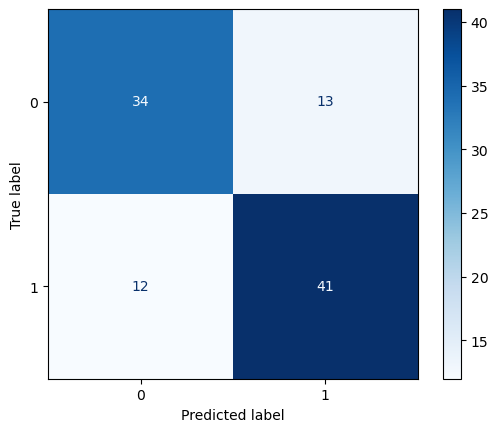

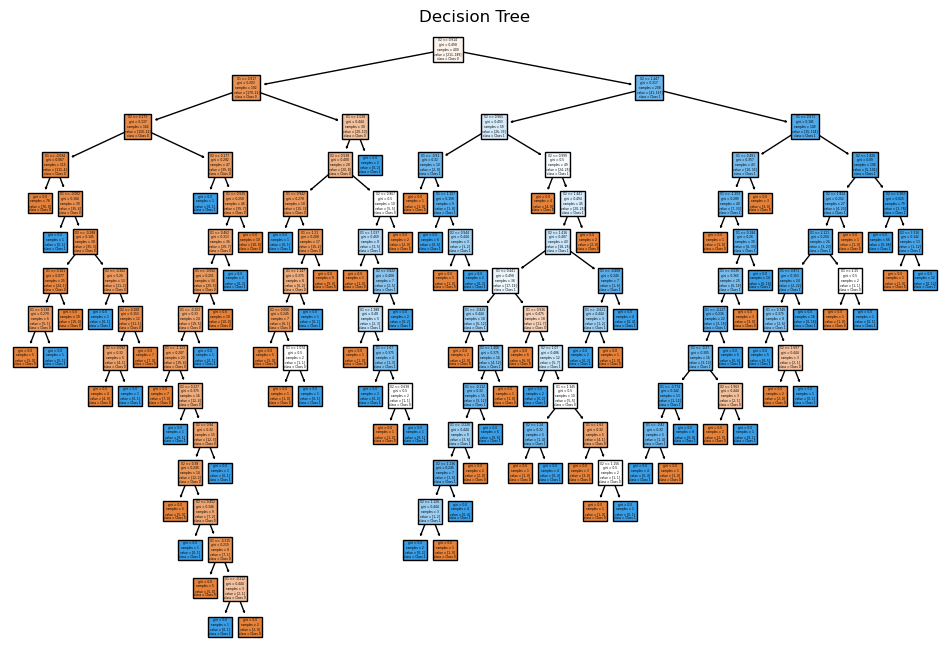

In [103]:
# Do a split to data N=500
X_train, X_test, Y_train, Y_test = train_test_split(samples_X[2], samples_Y[2], test_size=0.2, random_state=42)

# Instantiate a decisition tree and fit to data 
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, Y_train)

# Make predictions 
y_pred = clf.predict(X_test)

# Accuracy 
acc = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)
print(f"Accuracy de árbol de decisión: {acc:.2f}")
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=['X1', 'X2'], class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree')
plt.show()

Ahora, obtuvimos una secuencia de árboles podados, para cado uno de ellos existe un valor de alpha el cuál esta relacionado con la complejidad, ajustamos un árbol para cada alpha y seleccionamos aquel con el mejor poder predictivo. 

In [104]:
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


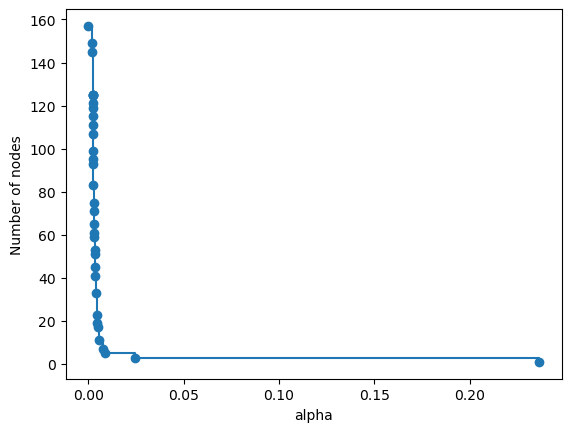

In [110]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)

# Plot the number of nodes as a function of alpha
number_nodes = [clf.tree_.node_count for clf in clfs]
plt.plot(path.ccp_alphas, number_nodes, marker="o", drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("Number of nodes")
plt.show()

Es interesante graficar el valor de alpha vs el accuracy, vemos como con valores dee alpha cercanos a cero, (árbol sin podar) hay un sobreajuste del modelo, y con alphas más grandes alcanzamos un buen balance entre el rendimiento en el conjunto de entrenamiento y validación. 

Valor de alpha con el mejor rendimiento en test data: 0.004337301587301587


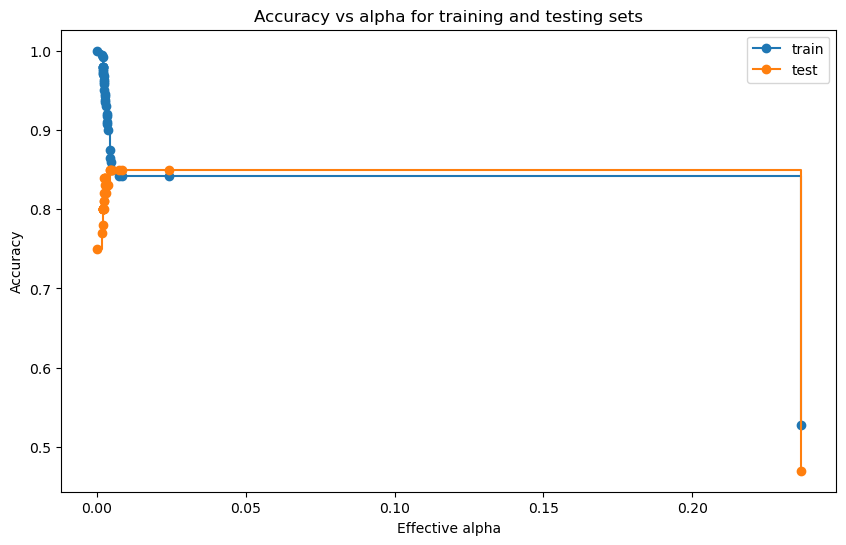

In [113]:
# Evaluate performance for each classifier 
train_scores = [clf.score(X_train, Y_train) for clf in clfs]
test_scores = [clf.score(X_test, Y_test) for clf in clfs]

best_alpha = ccp_alphas[np.argmax(test_scores)]
print(f"Valor de alpha con el mejor rendimiento en test data: {best_alpha}")

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
plt.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
plt.xlabel('Effective alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs alpha for training and testing sets')
plt.show()

Finalmente ajustamos un modelo con el mejor rendimiento en validación. 

Accuracy de árbol de decisión: 0.85
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        47
           1       0.85      0.87      0.86        53

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



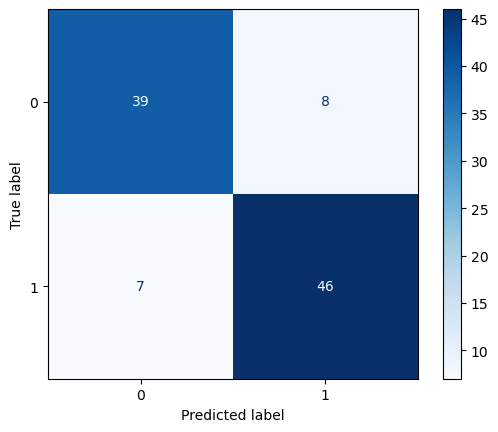

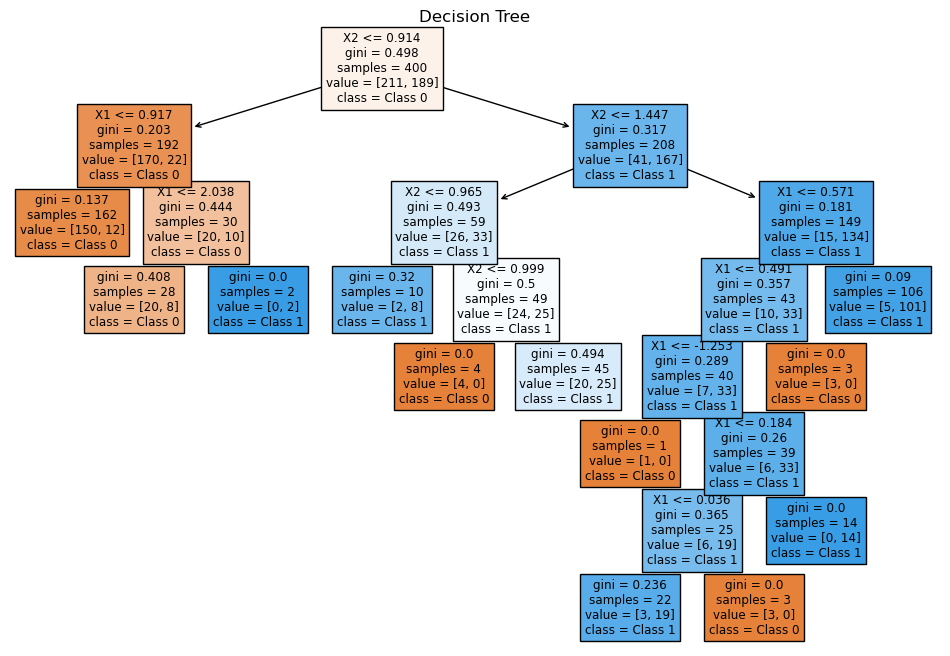

In [115]:
# Fit the model with the best alpha
clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_pruned.fit(X_train, Y_train)

# Make predictions 
y_pred = clf_pruned.predict(X_test)

# Accuracy 
acc = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)
print(f"Accuracy de árbol de decisión: {acc:.2f}")
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.figure(figsize=(12, 8))
plot_tree(clf_pruned, filled=True, feature_names=['X1', 'X2'], class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree')
plt.show()

### Logistic Regression 

Ahora ajustemos un modelo con efectos principales solamente y evaluemos el poder predictivo. 

In [121]:
# Fit a logistic regression model 
data_train = pd.DataFrame({
    "y"  : Y_train, 
    "x1" : X_train[:, 0], 
    "x2" : X_train[:, 1] 
})
data_test = pd.DataFrame({
    "y"  : Y_test, 
    "x1" : X_test[:, 0], 
    "x2" : X_test[:, 1] 
})

link_RL=sm.genmod.families.links.Logit

model = smf.glm(formula = "y ~ x1+x2",
               family=sm.families.Binomial(link_RL() ),
               data=data_train
               ).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:                            GLM   Df Residuals:                      397
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -142.82
Date:                Sat, 18 May 2024   Deviance:                       285.64
Time:                        19:54:45   Pearson chi2:                     441.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4879
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2206      0.268     -8.287      0.000      -2.746      -1.695
x1             0.5617      0.166      3.391      0.001       0.237       0.886
x2             1.8470      0.196      9.427      0.000       1.463       2.231
==============================================================================
"""

              precision    recall  f1-score   support

           0       0.78      0.81      0.79        47
           1       0.82      0.79      0.81        53

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



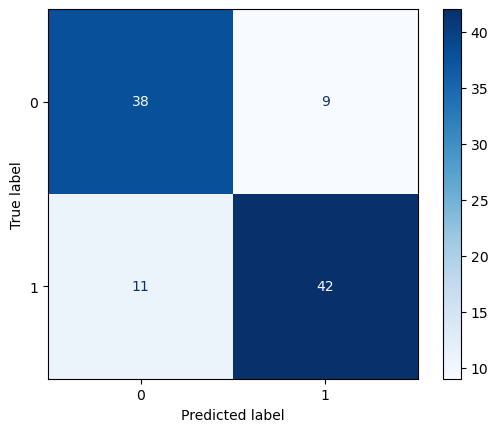

In [122]:
# Predict 
probs = model.predict(data_test)
y_pred = probs > 0.5

# Accuracy 
report = classification_report(Y_test, y_pred)
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Support Vector Machines 

Finalmente ajustemos un modelo basadp en SVM. 

In [124]:
# Instantiate a model 
clf = svm.SVC(kernel="linear", C=10)
clf.fit(X_train, Y_train)

SVC(C=10, kernel='linear')

(-10.0, 10.0)

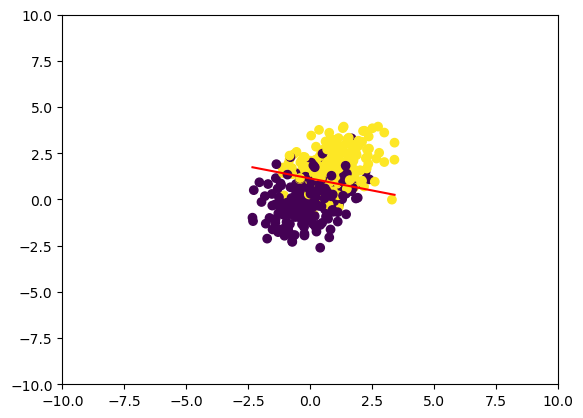

In [127]:
# Plot the discriminant line 
w = clf.coef_[0]
b = clf.intercept_[0]      # b consists of 1 element
x_points = np.linspace(np.min(X_train[:,0]), np.max(X_train[:,0]))    # generating x-points from -1 to 1
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# Plotting a red hyperplane
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
plt.plot(x_points, y_points, c='r');
plt.xlim(-10, 10)
plt.ylim(-10,10)

<Axes: >

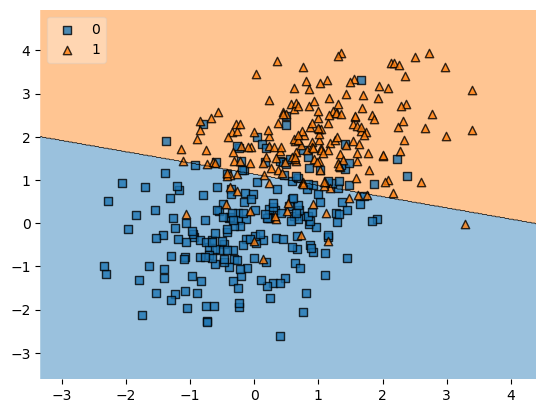

In [133]:
plot_decision_regions(X_train, Y_train, clf=clf, legend=2)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        47
           1       0.83      0.83      0.83        53

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100



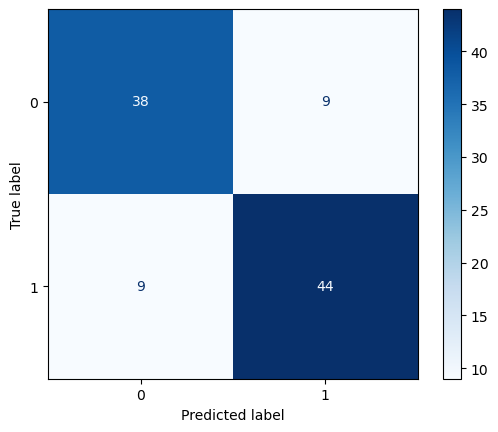

In [134]:
# Predict 
y_pred = clf.predict(X_test)

# Accuracy 
report = classification_report(Y_test, y_pred)
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(Y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)

## Cancer Data 

Primero carguemos los datos. 

In [29]:
# Load Data 
data = pd.read_csv('./breast+cancer/breast-cancer.data', header=None)
names = [
    "Class", "age", "menopause", "tumor-size", 
    "inv-nodes", "node-caps", "deg-malig", 
    "breast", "breast-quad", "irradiat"
]
data.columns = names
data.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [30]:
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Class        286 non-null    int64
 1   age          286 non-null    int64
 2   menopause    286 non-null    int64
 3   tumor-size   286 non-null    int64
 4   inv-nodes    286 non-null    int64
 5   node-caps    286 non-null    int64
 6   deg-malig    286 non-null    int64
 7   breast       286 non-null    int64
 8   breast-quad  286 non-null    int64
 9   irradiat     286 non-null    int64
dtypes: int64(10)
memory usage: 22.5 KB


In [32]:
X, y = data.drop(columns=['irradiat']), data['irradiat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

Decision Tree 

              precision    recall  f1-score   support

           0       0.78      0.93      0.84        41
           1       0.67      0.35      0.46        17

    accuracy                           0.76        58
   macro avg       0.72      0.64      0.65        58
weighted avg       0.74      0.76      0.73        58



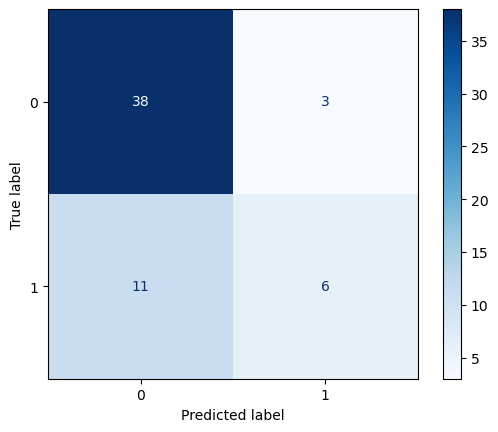

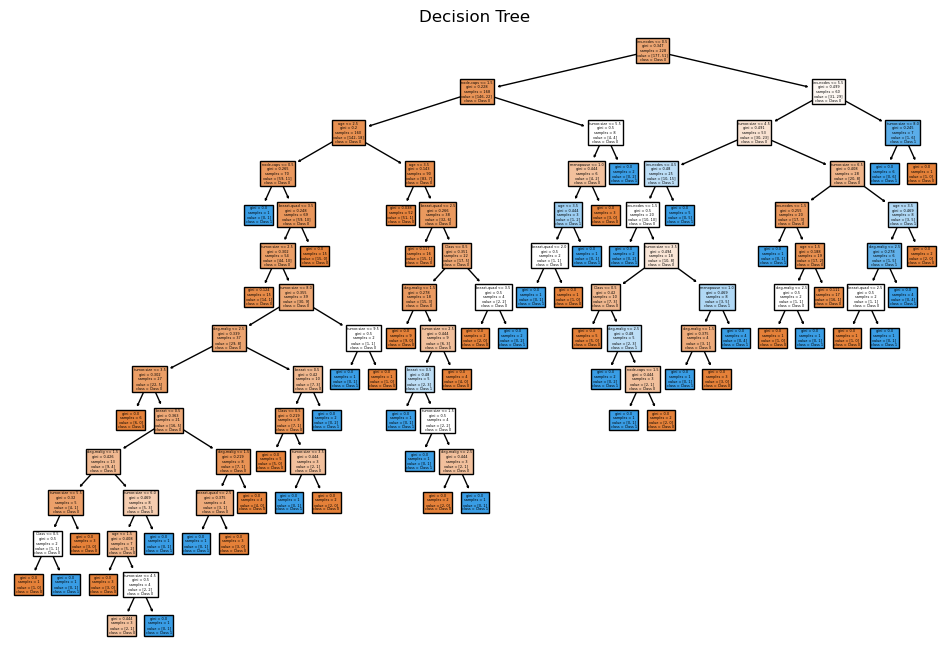

In [33]:
# ---> Decision Tree 
# Deepest Tree
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Cross Validation 
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

test_scores = [clf.score(X_test, y_test) for clf in clfs]
best_alpha = ccp_alphas[np.argmax(test_scores)]

# Fit the model with the best alpha
clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_pruned.fit(X_train, y_train)

# Make predictions 
y_pred = clf_pruned.predict(X_test)

# Accuracy 
report = classification_report(y_test, y_pred)
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()

plt.figure(figsize=(12, 8))
plot_tree(clf_pruned, filled=True, feature_names=names, class_names=['Class 0', 'Class 1'])
plt.title('Decision Tree')
plt.show()

Logistic Regression 

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  228
Model:                            GLM   Df Residuals:                      218
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -103.02
Date:                Sun, 19 May 2024   Deviance:                       206.04
Time:                        13:45:47   Pearson chi2:                     229.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1473
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8388      1.294     -2.194      0.0

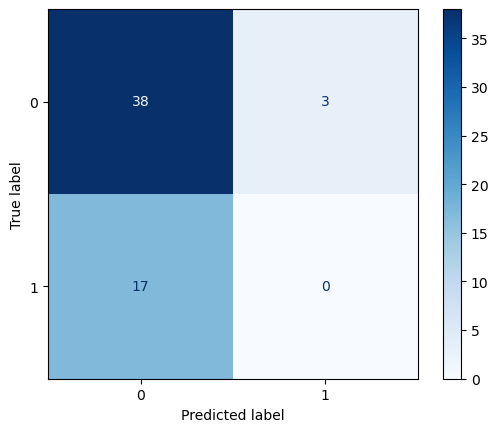

In [43]:
# Fit a logistic regression model 
data_train = pd.DataFrame({
    "y"  : y_train, 
    "x1" : X_train.iloc[:, 0], 
    "x2" : X_train.iloc[:, 1], 
    "x3" : X_train.iloc[:, 2], 
    "x4" : X_train.iloc[:, 3], 
    "x5" : X_train.iloc[:, 4], 
    "x6" : X_train.iloc[:, 5], 
    "x7" : X_train.iloc[:, 6], 
    "x8" : X_train.iloc[:, 7], 
    "x9" : X_train.iloc[:, 8], 
})
data_test = pd.DataFrame({
    "y"  : y_test, 
    "x1" : X_test.iloc[:, 0], 
    "x2" : X_test.iloc[:, 1], 
    "x3" : X_test.iloc[:, 2], 
    "x4" : X_test.iloc[:, 3], 
    "x5" : X_test.iloc[:, 4], 
    "x6" : X_test.iloc[:, 5], 
    "x7" : X_test.iloc[:, 6], 
    "x8" : X_test.iloc[:, 7], 
    "x9" : X_test.iloc[:, 8], 
})

link_RL=sm.genmod.families.links.Logit
model = smf.glm(formula = "y ~ x1+x2+x3+x4+x5+x6+x7+x8+x9",
               family=sm.families.Binomial(link_RL() ),
               data=data_train
               ).fit()
print(model.summary())

# Predict 
probs = model.predict(data_test)
y_pred = probs > 0.5

# Accuracy 
report = classification_report(y_test, y_pred)
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)
plt.show()


Support Vector Machine 

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        41
           1       0.67      0.47      0.55        17

    accuracy                           0.78        58
   macro avg       0.74      0.69      0.70        58
weighted avg       0.76      0.78      0.76        58



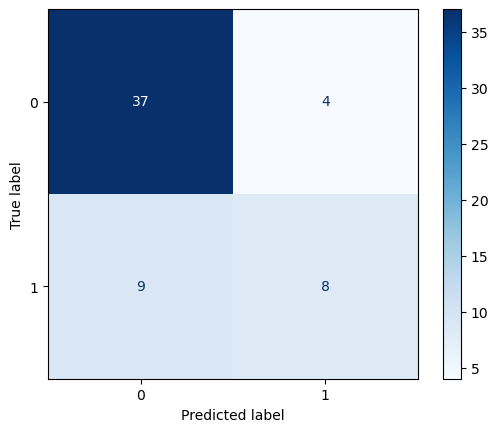

In [95]:
# Instantiate a model 
clf = svm.SVC(kernel="linear", C=10)
clf.fit(X_train, y_train)

# Predict 
y_pred = clf.predict(X_test)

# Accuracy 
report = classification_report(y_test, y_pred)
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)

              precision    recall  f1-score   support

           0       0.76      0.93      0.84        41
           1       0.62      0.29      0.40        17

    accuracy                           0.74        58
   macro avg       0.69      0.61      0.62        58
weighted avg       0.72      0.74      0.71        58



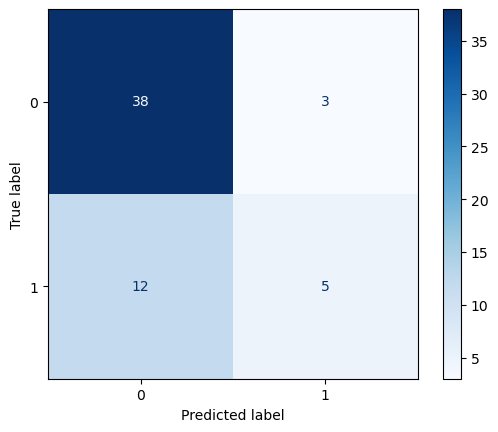

In [101]:
# Instantiate a model 
clf = svm.SVC(kernel="rbf", gamma=0.1, C=10)
clf.fit(X_train, y_train)

# Predict 
y_pred = clf.predict(X_test)

# Accuracy 
report = classification_report(y_test, y_pred)
print(report)

# Plot 
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(cmap=plt.cm.Blues)

Consideremos la siguiente función de costo:

$$
\sum_i \exp(-y_i g(x_i)) + \lambda ||\beta||^2, \quad g(x) = \alpha + \beta^T x
$$

Entonces, por la ley de los números grandes:

$$
\frac{1}{n} \sum_i \exp(-y_i g(x_i)) \rightarrow \mathbb{E}_{X,Y} \exp(-Y g(X))
$$

Esto nos permite plantear el siguiente problema:

$$
\min_{g} \mathbb{E}_{X,Y} \exp(-Y g(X))
$$

lo cual es equivalente a:

$$
\forall x: \min_{g(x)} \mathbb{E}_{Y|X=x} \exp(-Y g(x))
$$

Desarrollando la función objetivo para el caso binario:

$$
\exp(-g(x)) P(Y=1 \mid X=x) + \exp(g(x)) P(Y=-1 \mid X=x) \tag{1}
$$

Para que el problema de minimización esté bien planteado conviene acotar la función $g$:

$$
-1 \leq g(x) \leq 1
$$

Ahora, si $P(Y=1 \mid X=x) < P(Y=-1 \mid X=x)$, entonces:

$$
e^{-1} \left( P(Y=-1 \mid X=x) - P(Y=1 \mid X=x) \right) < e \left( P(Y=-1 \mid X=x) - P(Y=1 \mid X=x) \right)
$$

reacomodando términos:

$$
e \, P(Y=1 \mid X=x) + e^{-1} P(Y=-1 \mid X=x) < e^{-1} P(Y=1 \mid X=x) + e \, P(Y=-1 \mid X=x)
$$

Entonces para minimizar (1), $g(x) = -1$. 

Analogamente, si $P(Y=-1 \mid X=x) < P(Y=1 \mid X=x)$ tenemos que $g(x) = 1$, esto es, $g(x)$ es el clasificador Bayesiano óptimo.
